# MAML-TinyMPC: Meta-Learning for Quadrotor Control

This notebook implements Model-Agnostic Meta-Learning (MAML) integrated with TinyMPC for quadrotor control. We compare controller types on figure-8 trajectory tracking:

1. **Baseline TinyMPC**: Standard MPC with nominal parameters
2. **K_Best (Meta-learned)**: MPC initialized with MAML-trained parameters
<!-- 3. **Fine-tuned K***: Online adaptation of K_Best controller (commented out for now) -->

The system demonstrates how meta-learning can improve MPC initialization across quadrotor variants (different masses, arm lengths, inertias).

## 1. Import Libraries and Setup

In [89]:
import math
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
from control import dlqr
import time
from scipy.spatial.transform import Rotation as spRot
np.set_printoptions(precision=4, suppress=True)

# Quadrotor physical parameters (nominal)
mass = 0.035  # kg
J = np.array([[16.6e-6, 0.83e-6, 0.72e-6],
              [0.83e-6, 16.6e-6, 1.8e-6],
              [0.72e-6, 1.8e-6, 29.3e-6]])  # kg*m^2
g = 9.81  # m/s^2
thrustToTorque = 0.0008
el = 0.046/1.414213562  # m
scale = 65535
kt = 2.245365e-6*scale
km = kt*thrustToTorque

# Control parameters
freq = 50.0  # Hz
h = 1/freq   # sampling time
Nx1 = 13     # full state dimension (with quaternions)
Nx = 12      # reduced state dimension (error coordinates)
Nu = 4       # control dimension

print("Libraries imported successfully!")
print(f"Quadrotor parameters loaded: mass={mass}kg, freq={freq}Hz")

Libraries imported successfully!
Quadrotor parameters loaded: mass=0.035kg, freq=50.0Hz


## 2. Quadrotor Dynamics and Reference Trajectory

In [90]:
def generate_figure8_reference(t):
    """Generate figure-8 reference with smooth start"""
    # Figure 8 parameters
    A = 0.5
    w = 2*np.pi/7
    
    # Smooth start factor (ramps up in first second)
    smooth_start = min(t/1.0, 1.0)
    
    x_ref = np.zeros(12)
    
    # Positions with smooth start
    x_ref[0] = A * np.sin(w*t) * smooth_start
    x_ref[2] = A * np.sin(2*w*t)/2 * smooth_start
    
    # Velocities (derivatives with smooth start)
    x_ref[6] = A * w * np.cos(w*t) * smooth_start 
    x_ref[8] = A * w * np.cos(2*w*t) * smooth_start
    
    # Zero attitude and angular velocity
    x_ref[3:6] = np.zeros(3)
    x_ref[9:12] = np.zeros(3)
    
    return x_ref

# Quaternion functions
def hat(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0.0]])

def L(q):
    s = q[0]
    v = q[1:4]
    up = np.hstack([s, -v])
    down = np.hstack([v.reshape(3,1), s*np.eye(3) + hat(v)])
    L = np.vstack([up,down])
    return L

T = np.diag([1.0, -1, -1, -1])
H = np.vstack([np.zeros((1,3)), np.eye(3)])

def qtoQ(q):
    return H.T @ T @ L(q) @ T @ L(q) @ H

def G(q):
    return L(q) @ H

def rptoq(phi):
    return (1./math.sqrt(1+phi.T @ phi)) * np.hstack([1, phi])

def qtorp(q):
    return q[1:4]/q[0]

def E(q):
    up = np.hstack([np.eye(3), np.zeros((3,3)), np.zeros((3,6))])
    mid = np.hstack([np.zeros((4,3)), G(q), np.zeros((4,6))])
    down = np.hstack([np.zeros((6,3)), np.zeros((6,3)), np.eye(6)])
    E = np.vstack([up, mid, down])
    return E

In [91]:
def quad_dynamics(x, u):
    r = x[0:3]
    q = x[3:7]/norm(x[3:7])
    v = x[7:10]
    omg = x[10:13]
    Q = qtoQ(q)

    dr = v
    dq = 0.5*L(q)@H@omg
    dv = np.array([0, 0, -g]) + (1/mass)*Q@np.array([[0, 0, 0, 0], 
                                                     [0, 0, 0, 0], 
                                                     [kt, kt, kt, kt]])@u
    domg = inv(J)@(-hat(omg)@J@omg + 
                   np.array([[-el*kt, -el*kt, el*kt, el*kt], 
                            [-el*kt, el*kt, el*kt, -el*kt], 
                            [-km, km, -km, km]])@u)

    return np.hstack([dr, dq, dv, domg])

def quad_dynamics_rk4(x, u):
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xnormalized = xn[3:7]/norm(xn[3:7])
    return np.hstack([xn[0:3], xnormalized, xn[7:13]])

## 3. TinyMPC Implementation

In [92]:
class TinyMPC:
    def __init__(self, input_data, Nsteps, mode=0):
        self.cache = {}
        self.cache['rho'] = input_data['rho']
        self.cache['A'] = input_data['A']
        self.cache['B'] = input_data['B']
        self.cache['Q'] = input_data['Q']
        self.cache['R'] = input_data['R']

        self.compute_cache_terms()
        self.set_tols_iters()
        self.x_prev = np.zeros((self.cache['A'].shape[0], Nsteps))
        self.u_prev = np.zeros((self.cache['B'].shape[1], Nsteps))
        self.N = Nsteps
        
    def compute_cache_terms(self):
        # Use copies to avoid in-place modification of Q/R
        Q_rho = self.cache['Q'].copy()
        R_rho = self.cache['R'].copy()
        R_rho += self.cache['rho'] * np.eye(R_rho.shape[0])
        Q_rho += self.cache['rho'] * np.eye(Q_rho.shape[0])

        A = self.cache['A']
        B = self.cache['B']
        Kinf = np.zeros(B.T.shape)
        Pinf = np.copy(self.cache['Q'])
        
        for k in range(5000):
            Kinf_prev = np.copy(Kinf)
            Kinf = inv(R_rho + B.T @ Pinf @ B) @ (B.T @ Pinf @ A)
            Pinf = Q_rho + A.T @ Pinf @ (A - B @ Kinf)
            
            if np.linalg.norm(Kinf - Kinf_prev, 2) < 1e-10:
                break

        AmBKt = (A - B @ Kinf).T
        Quu_inv = np.linalg.inv(R_rho + B.T @ Pinf @ B)

        self.cache['Kinf'] = Kinf
        self.cache['Pinf'] = Pinf
        self.cache['C1'] = Quu_inv
        self.cache['C2'] = AmBKt
        
    def _compute_policy_cache(self, K):
        """Replace internal base policy with K and rebuild caches via policy evaluation.
        This treats K as the unconstrained baseline and computes P from the discrete Lyapunov equation.
        """
        A = self.cache['A']; B = self.cache['B']
        Q = self.cache['Q']; R = self.cache['R']
        rho = self.cache['rho']

        Ak = A - B @ K

        # Policy evaluation: solve P = Q + K^T R K + (A-BK)^T P (A-BK)
        # Start from the stage cost
        P = Q + K.T @ R @ K
        for _ in range(1000):
            Pn = Q + K.T @ R @ K + Ak.T @ P @ Ak
            if np.linalg.norm(Pn - P, ord='fro') < 1e-9:
                P = Pn
                break
            P = Pn

        # Build ADMM-augmented matrices (add rho penalty like standard Riccati does)
        # This ensures C1 and the backward pass are consistent with ADMM's augmented Lagrangian
        P_rho = P + rho * np.eye(P.shape[0])
        R_rho = R + rho * np.eye(R.shape[0])
        
        Quu_inv = np.linalg.inv(R_rho + B.T @ P_rho @ B)

        self.cache['Kinf'] = K               # reuse the same key used by forward/backward
        self.cache['Pinf'] = P               # terminal cost (non-augmented for final cost)
        self.cache['C1'] = Quu_inv
        self.cache['C2'] = Ak.T

    def set_policy(self, Kpol):
        """Public API to set the base policy (e.g., K_meta) inside TinyMPC and recompute caches."""
        self.cache['Kpol'] = Kpol.copy()
        self._compute_policy_cache(self.cache['Kpol'])

    def set_model(self, A, B):
        """Public API to update the linear model and recompute caches with the current policy if any."""
        self.cache['A'] = A.copy()
        self.cache['B'] = B.copy()
        if 'Kpol' in self.cache:
            self._compute_policy_cache(self.cache['Kpol'])
        else:
            self.compute_cache_terms()
        
    def backward_pass_grad(self, d, p, q, r):
        for k in range(self.N-2, -1, -1):
            d[:, k] = np.dot(self.cache['C1'], np.dot(self.cache['B'].T, p[:, k + 1]) + r[:, k])
            p[:, k] = q[:, k] + np.dot(self.cache['C2'], p[:, k + 1]) - np.dot(self.cache['Kinf'].T, r[:, k])

    def forward_pass(self, x, u, d):
        for k in range(self.N - 1):
            u[:, k] = -np.dot(self.cache['Kinf'], x[:, k]) - d[:, k]
            x[:, k + 1] = np.dot(self.cache['A'], x[:, k]) + np.dot(self.cache['B'], u[:, k])

    def update_primal(self, x, u, d, p, q, r):
        self.backward_pass_grad(d, p, q, r)
        self.forward_pass(x, u, d)

    def update_slack(self, z, v, y, g, u, x, umax=None, umin=None, xmax=None, xmin=None):
        for k in range(self.N - 1):
            z[:, k] = u[:, k] + y[:, k]
            v[:, k] = x[:, k] + g[:, k]

            if (umin is not None) and (umax is not None):
                z[:, k] = np.clip(z[:, k], umin, umax)

            if (xmin is not None) and (xmax is not None):
                v[:, k] = np.clip(v[:, k], xmin, xmax)

        v[:, self.N-1] = x[:, self.N-1] + g[:, self.N-1]
        if (xmin is not None) and (xmax is not None):
            v[:, self.N-1] = np.clip(v[:, self.N-1], xmin, xmax)

    def update_dual(self, y, g, u, x, z, v):
        for k in range(self.N - 1):
            y[:, k] += u[:, k] - z[:, k]
            g[:, k] += x[:, k] - v[:, k]
        g[:, self.N-1] += x[:, self.N-1] - v[:, self.N-1]

    def update_linear_cost(self, r, q, p, z, v, y, g, u_ref, x_ref):
        for k in range(self.N - 1):
            r[:, k] = -self.cache['R'] @ u_ref[:, k]
            r[:, k] -= self.cache['rho'] * (z[:, k] - y[:, k])

            q[:, k] = -self.cache['Q'] @ x_ref[:, k]
            q[:, k] -= self.cache['rho'] * (v[:, k] - g[:, k])

        p[:,self.N-1] = -np.dot(self.cache['Pinf'], x_ref[:, self.N-1])
        p[:,self.N-1] -= self.cache['rho'] * (v[:, self.N-1] - g[:, self.N-1])

        self.cache['q'] = q.copy()
        
    def set_bounds(self, umax=None, umin=None, xmax=None, xmin=None):
        if (umin is not None) and (umax is not None):
            self.umin = umin
            self.umax = umax
        if (xmin is not None) and (xmax is not None):
            self.xmin = xmin
            self.xmax = xmax
        
    def set_tols_iters(self, max_iter=100, abs_pri_tol=1e-3, abs_dua_tol=1e-3):
        self.max_iter = max_iter
        self.abs_pri_tol = abs_pri_tol
        self.abs_dua_tol = abs_dua_tol
        
    def solve_admm(self, x_init, u_init, x_ref=None, u_ref=None, current_time=None):
        status = 0
        x = np.copy(x_init)
        u = np.copy(u_init)
        v = np.zeros(x.shape)
        z = np.zeros(u.shape)
        v_prev = np.zeros(x.shape)
        z_prev = np.zeros(u.shape)
        g = np.zeros(x.shape)
        y = np.zeros(u.shape)
        q = np.zeros(x.shape)
        r = np.zeros(u.shape)
        p = np.zeros(x.shape)
        d = np.zeros(u.shape)

        if (x_ref is None):
            x_ref = np.zeros(x.shape)
        if (u_ref is None):
            u_ref = np.zeros(u.shape)

        for k in range(self.max_iter):
            self.update_primal(x, u, d, p, q, r)
            self.update_slack(z, v, y, g, u, x, self.umax, self.umin, self.xmax, self.xmin)
            self.update_dual(y, g, u, x, z, v)
            self.update_linear_cost(r, q, p, z, v, y, g, u_ref, x_ref)

            pri_res_input = np.max(np.abs(u - z))
            pri_res_state = np.max(np.abs(x - v))
            dua_res_input = np.max(np.abs(self.cache['rho'] * (z_prev - z)))
            dua_res_state = np.max(np.abs(self.cache['rho'] * (v_prev - v)))

            pri_res = max(pri_res_input, pri_res_state)
            dual_res = max(dua_res_input, dua_res_state)

            z_prev = np.copy(z)
            v_prev = np.copy(v)

            if (pri_res < self.abs_pri_tol and dual_res < self.abs_dua_tol):
                status = 1
                break

        self.x_prev = x
        self.u_prev = u
        return x, u, status, k

## 4. Task Distribution for Quadrotor Variants

In [93]:
def generate_perturbed_samples(A, N, epsilon, symmetric=None):
    """Generate N samples perturbed from matrix A"""
    perturbed_samples = [A.copy()]
    
    for _ in range(N-1):
        while True:
            P = np.random.randn(*A.shape)
            if symmetric:
                P = (P + P.T) / 2
            
            P_scaled = (P / np.linalg.norm(P, ord=2)) * epsilon * 0.6
            A_perturbed = A + P_scaled
            
            if all(np.linalg.norm(A_perturbed - other, ord=2) < epsilon for other in perturbed_samples):
                perturbed_samples.append(A_perturbed)
                break
    
    return perturbed_samples

class QuadrotorTaskGenerator:
    def __init__(self, A_nom, B_nom, Q_nom, R_nom, M=10, heterogeneity_type='system_cost', eps=[0.01, 0.01]):
        """
        Generate M quadrotor tasks with heterogeneity
        
        Parameters:
        A_nom, B_nom: Nominal system matrices
        Q_nom, R_nom: Nominal cost matrices  
        M: Number of tasks
        heterogeneity_type: 'system', 'cost', or 'system_cost'
        eps: Heterogeneity levels [system_eps, cost_eps]
        """
        self.A_nom = A_nom
        self.B_nom = B_nom
        self.Q_nom = Q_nom
        self.R_nom = R_nom
        self.M = M
        self.heterogeneity_type = heterogeneity_type
        
        # Generate task variations
        if heterogeneity_type == 'system':
            self.A_tasks = generate_perturbed_samples(A_nom, M, eps[0])
            self.B_tasks = generate_perturbed_samples(B_nom, M, eps[1])
            self.Q_tasks = [Q_nom.copy() for _ in range(M)]
            self.R_tasks = [R_nom.copy() for _ in range(M)]
            
        elif heterogeneity_type == 'cost':
            self.Q_tasks = generate_perturbed_samples(Q_nom, M, eps[0], symmetric=True)
            self.R_tasks = generate_perturbed_samples(R_nom, M, eps[1], symmetric=True)
            self.A_tasks = [A_nom.copy() for _ in range(M)]
            self.B_tasks = [B_nom.copy() for _ in range(M)]
            
        else:  # system_cost
            self.A_tasks = generate_perturbed_samples(A_nom, M, eps[0])
            self.B_tasks = generate_perturbed_samples(B_nom, M, eps[1])
            self.Q_tasks = generate_perturbed_samples(Q_nom, M, eps[0], symmetric=True)
            self.R_tasks = generate_perturbed_samples(R_nom, M, eps[1], symmetric=True)
            
        # Compute optimal controllers for each task
        self.K_optimal = []
        for i in range(M):
            try:
                K_opt, _, _ = dlqr(self.A_tasks[i], self.B_tasks[i], self.Q_tasks[i], self.R_tasks[i])
                self.K_optimal.append(np.array(K_opt))
            except:
                # Fallback to nominal
                K_opt, _, _ = dlqr(A_nom, B_nom, Q_nom, R_nom)
                self.K_optimal.append(np.array(K_opt))
    
    def sample_task(self, task_idx):
        """Sample a specific task"""
        return {
            'A': self.A_tasks[task_idx],
            'B': self.B_tasks[task_idx], 
            'Q': self.Q_tasks[task_idx],
            'R': self.R_tasks[task_idx],
            'K_opt': self.K_optimal[task_idx]
        }
    
    def compute_task_cost(self, task_idx, K, x0, N):
        """Compute LQR cost for a policy on a task"""
        task = self.sample_task(task_idx)
        return lqr_cost_finite_horizon(task['A'], task['B'], task['Q'], task['R'], K, x0, N)
    
    def compute_task_gradient(self, task_idx, K, x0, N):
        """Compute gradient of LQR cost w.r.t. K"""
        task = self.sample_task(task_idx)
        return grad_lqr_cost(task['A'], task['B'], task['Q'], task['R'], K, x0, N)

def lqr_cost_finite_horizon(A, B, Q, R, K, x0, N):
    """Compute finite horizon LQR cost"""
    cost = 0
    x = x0.copy()
    for t in range(N):
        u = -K @ x
        cost += x.T @ Q @ x + u.T @ R @ u
        x = A @ x + B @ u
    return cost

def grad_lqr_cost(A, B, Q, R, K, x0, N):
    """Compute gradient of LQR cost w.r.t. K using finite differences"""
    eps = 1e-6
    grad = np.zeros_like(K)
    
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K_plus = K.copy()
            K_minus = K.copy()
            K_plus[i,j] += eps
            K_minus[i,j] -= eps
            
            cost_plus = lqr_cost_finite_horizon(A, B, Q, R, K_plus, x0, N)
            cost_minus = lqr_cost_finite_horizon(A, B, Q, R, K_minus, x0, N)
            
            grad[i,j] = (cost_plus - cost_minus) / (2 * eps)
    
    return grad

## 5. MAML Implementation

In [94]:
def maml_update(task_generator, K_meta, alpha, beta, N_horizon, x0_samples):
    """Perform one MAML update step"""
    M = task_generator.M
    K_adapted = []
    gradients = []
    
    # Inner loop: adapt to each task
    for i in range(M):
        K_task = K_meta.copy()
        
        # Single inner gradient step
        grad_sum = np.zeros_like(K_task)
        for x0 in x0_samples:
            grad_inner = task_generator.compute_task_gradient(i, K_task, x0, N_horizon)
            grad_inner = np.clip(grad_inner, -10, 10)  # Clip gradients
            grad_sum += grad_inner
        
        K_task = K_task - alpha * (grad_sum / len(x0_samples))
        K_adapted.append(K_task)
        
        # Compute meta-gradient
        meta_grad = np.zeros_like(K_meta)
        for x0 in x0_samples:
            grad_outer = task_generator.compute_task_gradient(i, K_task, x0, N_horizon)
            grad_outer = np.clip(grad_outer, -10, 10)
            meta_grad += grad_outer
        
        gradients.append(meta_grad / len(x0_samples))
    
    # Outer loop: meta-update
    meta_gradient = np.mean(gradients, axis=0)
    meta_gradient = np.clip(meta_gradient, -1, 1)
    K_meta_new = K_meta - beta * meta_gradient
    
    return K_meta_new, K_adapted

def train_maml_controller(task_generator, K_init, alpha, beta, N_maml_iters, N_horizon, x0_samples):
    """Train MAML controller"""
    K_meta = K_init.copy()
    meta_losses = []
    
    print("Starting MAML training...")
    for iter in range(N_maml_iters):
        K_meta, K_adapted = maml_update(task_generator, K_meta, alpha, beta, N_horizon, x0_samples)
        
        # Compute meta-loss
        meta_loss = 0
        for i in range(task_generator.M):
            task_loss = 0
            for x0 in x0_samples:
                task_loss += task_generator.compute_task_cost(i, K_adapted[i], x0, N_horizon)
            meta_loss += task_loss / len(x0_samples)
        meta_loss /= task_generator.M
        meta_losses.append(meta_loss)
        
        if iter % 10 == 0:
            print(f"MAML Iteration {iter}: Meta-loss = {meta_loss:.4f}")
    
    print("MAML training completed!")
    return K_meta, meta_losses

## 6. Controller Definitions

In [95]:
def delta_x_quat(x_curr, t):
    """Compute error between current state and reference"""
    x_ref = generate_figure8_reference(t)
    
    # Current quaternion
    q = x_curr[3:7]
    
    # Reference quaternion (hover)
    q_ref = np.array([1.0, 0.0, 0.0, 0.0])
    
    # Quaternion error
    phi = qtorp(L(q_ref).T @ q)
    
    # Full state error (12 dimensions)
    delta_x = np.hstack([
        x_curr[0:3] - x_ref[0:3],    # position error
        phi,                          # attitude error (3 components)
        x_curr[7:10] - x_ref[6:9],   # velocity error
        x_curr[10:13] - x_ref[9:12]  # angular velocity error
    ])
    return delta_x

class QuadrotorController:
    def __init__(self, controller_type, system_matrices, K_meta=None):
        """
        Initialize controller
        
        Parameters:
        controller_type: 'baseline', 'k_best', 'fine_tuned'
        system_matrices: dict with A, B, Q, R
        K_meta: Meta-learned controller (for k_best and fine_tuned)
        """
        self.controller_type = controller_type
        self.A = system_matrices['A']
        self.B = system_matrices['B']
        self.Q = system_matrices['Q']
        self.R = system_matrices['R']
        
        # MPC parameters
        self.N = 25  # horizon
        self.rho = 5.0  # ADMM parameter
        
        # Setup TinyMPC
        input_data = {
            'rho': self.rho,
            'A': self.A,
            'B': self.B,
            'Q': self.Q,
            'R': self.R
        }
        
        self.tinympc = TinyMPC(input_data, self.N)
        
        # Set bounds
        uhover = (mass*g/kt/4)*np.ones(4)
        # Keep the controller operating in absolute space: MPC solves for delta u, add hover later
        u_max = [1.0-uhover[0]] * Nu
        u_min = [-1*uhover[0]] * Nu
        x_max = [2.] * Nx
        x_min = [-2.0] * Nx
        self.tinympc.set_bounds(u_max, u_min, x_max, x_min)
        
        # Controller-specific initialization
        if controller_type == 'baseline':
            # Use nominal LQR initialization as base policy
            K_opt, _, _ = dlqr(self.A, self.B, self.Q, self.R)
            self.K_init = np.array(K_opt)
            # Install the base policy into TinyMPC
            self.tinympc.set_policy(self.K_init)
            
        elif controller_type in ['k_best', 'fine_tuned']:
            if K_meta is None:
                raise ValueError("K_meta required for k_best and fine_tuned controllers")
            self.K_meta = K_meta.copy()
            self.K_current = K_meta.copy()  # For fine-tuning
            # Install K_meta as the base policy in TinyMPC
            self.tinympc.set_policy(self.K_meta)
        
        # Hover control
        self.uhover = (mass*g/kt/4)*np.ones(4)
    
    def get_control(self, x_curr, t):
        """Get control input for current state"""
        # Generate reference trajectory for horizon
        x_ref = np.zeros((Nx, self.N))
        u_ref = np.zeros((Nu, self.N-1))
        
        for i in range(self.N):
            x_ref[:,i] = generate_figure8_reference(t + i*h)
        # Reference input is hover thrust across horizon
        u_ref[:] = 0.0  # MPC solves in delta-u; hover added back after solve

        delta_x = delta_x_quat(x_curr, t)
        
        # Initialize trajectories
        x_init = np.copy(self.tinympc.x_prev)
        x_init[:,0] = delta_x
        u_init = np.copy(self.tinympc.u_prev)
        
        # Warm-start initial input using the installed base policy
        if self.controller_type == 'baseline':
            u_init[:,0] = -self.K_init @ delta_x
        elif self.controller_type == 'k_best':
            u_init[:,0] = -self.K_meta @ delta_x
        elif self.controller_type == 'fine_tuned':
            u_init[:,0] = -self.K_current @ delta_x
            # Placeholder: adaptation will be added later
        
        # Solve MPC
        x_out, u_out, status, k = self.tinympc.solve_admm(x_init, u_init, x_ref, u_ref, t)
        
        # Safety clamp: enforce bounds on the applied delta-u even if ADMM hasn't fully converged
        u_delta = u_out[:, 0]
        if hasattr(self.tinympc, 'umin') and hasattr(self.tinympc, 'umax'):
            u_delta = np.clip(u_delta, self.tinympc.umin, self.tinympc.umax)
        # Guard against NaNs/Infs
        if not np.all(np.isfinite(u_delta)):
            u_delta = np.zeros_like(u_delta)
        
        # Return control with hover offset added back
        return self.uhover + u_delta

In [96]:
def simulate_controller(controller, x0, T_sim=10.0):
    """Simulate controller for T_sim seconds"""
    dt = h
    N_steps = int(T_sim / dt)
    
    x_all = []
    u_all = []
    x_curr = x0.copy()
    
    for i in range(N_steps):
        t = i * dt
        u_curr = controller.get_control(x_curr, t)
        
        # Simulate dynamics
        x_curr = quad_dynamics_rk4(x_curr, u_curr)
        
        # Store results
        x_all.append(x_curr.copy())
        u_all.append(u_curr.copy())
    
    return np.array(x_all), np.array(u_all)

## 7. Main Experiment: Training and Evaluation

In [97]:
# Setup nominal system
rg = np.array([0.0, 0, 0.0])
qg = np.array([1.0, 0, 0, 0])
vg = np.zeros(3)
omgg = np.zeros(3)
xg = np.hstack([rg, qg, vg, omgg])
uhover = (mass*g/kt/4)*np.ones(4)

A_jac = jacobian(quad_dynamics_rk4, 0)
B_jac = jacobian(quad_dynamics_rk4, 1)

Anp1 = A_jac(xg, uhover)
Bnp1 = B_jac(xg, uhover)

Anp = E(qg).T @ Anp1 @ E(qg)
Bnp = E(qg).T @ Bnp1

# Cost matrices
max_dev_x = np.array([
    0.01, 0.01, 0.01,    # position
    0.5, 0.5, 0.05,      # attitude
    0.5, 0.5, 0.5,       # velocity
    0.7, 0.7, 0.5        # angular velocity
])
max_dev_u = np.array([0.1, 0.1, 0.1, 0.1])

Q = np.diag(1./(max_dev_x**2))
R = np.diag(1./(max_dev_u**2))

system_matrices = {
    'A': Anp,
    'B': Bnp,
    'Q': Q,
    'R': R
}

print("System matrices computed successfully!")

System matrices computed successfully!


In [98]:
# Create task distribution
M_tasks = 8
eps = [0.02, 0.02]  # System and cost heterogeneity
task_generator = QuadrotorTaskGenerator(Anp, Bnp, Q, R, M=M_tasks, 
                                       heterogeneity_type='system_cost', eps=eps)

print(f"Created {M_tasks} heterogeneous quadrotor tasks")

# Sample initial states for MAML
x0_samples = [np.random.normal(0, 0.1, Nx) for _ in range(3)]

# Initialize with nominal LQR
K_init, _, _ = dlqr(Anp, Bnp, Q, R)
K_init = np.array(K_init)

# Train MAML controller
alpha = 1e-4  # Inner loop learning rate
beta = 1e-3   # Meta learning rate
N_maml_iters = 50
N_horizon = 20

K_meta, meta_losses = train_maml_controller(task_generator, K_init, alpha, beta, 
                                           N_maml_iters, N_horizon, x0_samples)

print(f"MAML training completed. Final meta-loss: {meta_losses[-1]:.4f}")

Created 8 heterogeneous quadrotor tasks
Starting MAML training...
MAML Iteration 0: Meta-loss = 6559.4887
MAML Iteration 0: Meta-loss = 6559.4887
MAML Iteration 10: Meta-loss = 6415.8410
MAML Iteration 10: Meta-loss = 6415.8410
MAML Iteration 20: Meta-loss = 6373.7184
MAML Iteration 20: Meta-loss = 6373.7184
MAML Iteration 30: Meta-loss = 6364.0878
MAML Iteration 30: Meta-loss = 6364.0878
MAML Iteration 40: Meta-loss = 6358.4018
MAML Iteration 40: Meta-loss = 6358.4018
MAML training completed!
MAML training completed. Final meta-loss: 6348.6709
MAML training completed!
MAML training completed. Final meta-loss: 6348.6709


In [99]:
# Create controllers
baseline_controller = QuadrotorController('baseline', system_matrices)
kbest_controller = QuadrotorController('k_best', system_matrices, K_meta)
# finetuned_controller = QuadrotorController('fine_tuned', system_matrices, K_meta)  # K* - commented out

controllers = {
    'Baseline MPC': baseline_controller,
    'K_Best (MAML)': kbest_controller,
    # 'Fine-tuned K*': finetuned_controller  # K* - commented out for now
}

print("Controllers initialized successfully with TinyMPC base policies set.")

Controllers initialized successfully with TinyMPC base policies set.


In [100]:
# Initial state
x0 = np.copy(xg)
x0[0:3] = np.array([0.0, 0.0, 0.0])  # Start at origin
x0[3:7] = rptoq(np.array([0.0, 0.0, 0.0]))  # Zero attitude error

# Simulation parameters
T_sim = 8.0  # seconds (approximately one figure-8)

# Run simulations
results = {}
for name, controller in controllers.items():
    print(f"Simulating {name}...")
    x_traj, u_traj = simulate_controller(controller, x0, T_sim)
    results[name] = {'x': x_traj, 'u': u_traj}
    print(f"{name} simulation completed")

print("All simulations completed!")

Simulating Baseline MPC...
Baseline MPC simulation completed
Simulating K_Best (MAML)...
Baseline MPC simulation completed
Simulating K_Best (MAML)...
K_Best (MAML) simulation completed
All simulations completed!
K_Best (MAML) simulation completed
All simulations completed!


## 8. Results and Visualization

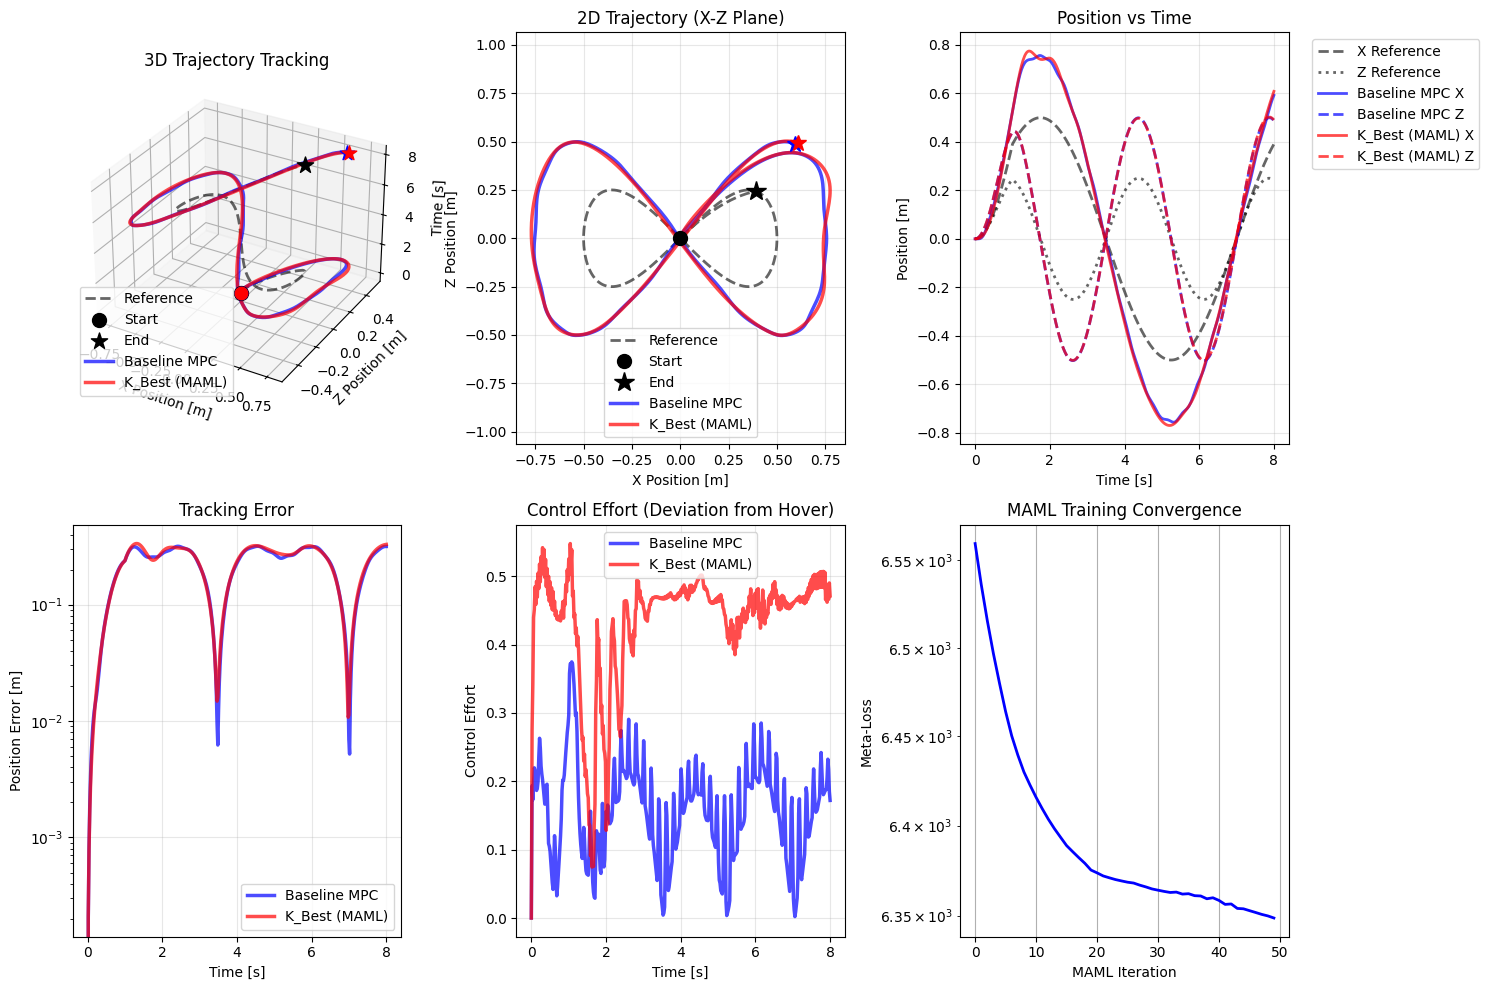

Quantitative Results:
Baseline MPC:
  Average tracking error: 0.2192 m
  Average control effort: 0.1559

K_Best (MAML):
  Average tracking error: 0.2234 m
  Average control effort: 0.4339



In [101]:
# Plot results
plt.figure(figsize=(15, 10))

# Generate reference trajectory
t_ref = np.linspace(0, T_sim, int(T_sim/h))
x_ref_traj = np.array([generate_figure8_reference(t) for t in t_ref])

# Plot 1: 3D Trajectory
ax1 = plt.subplot(2, 3, 1, projection='3d')
ax1.plot(x_ref_traj[:, 0], x_ref_traj[:, 2], t_ref, 'k--', linewidth=2, alpha=0.6, label='Reference')
# Plot start and end points for reference
ax1.scatter(x_ref_traj[0, 0], x_ref_traj[0, 2], t_ref[0], color='black', s=100, marker='o', label='Start', zorder=5)
ax1.scatter(x_ref_traj[-1, 0], x_ref_traj[-1, 2], t_ref[-1], color='black', s=150, marker='*', label='End', zorder=5)

colors = ['blue', 'red', 'green']
for i, (name, result) in enumerate(results.items()):
    x_traj = result['x']
    ax1.plot(x_traj[:, 0], x_traj[:, 2], t_ref[:len(x_traj)], 
             color=colors[i], linewidth=2.5, alpha=0.7, label=name)
    # Plot start and end points
    ax1.scatter(x_traj[0, 0], x_traj[0, 2], t_ref[0], color=colors[i], s=80, marker='o', zorder=4)
    ax1.scatter(x_traj[-1, 0], x_traj[-1, 2], t_ref[len(x_traj)-1], color=colors[i], s=120, marker='*', zorder=4)
ax1.set_xlabel('X Position [m]')
ax1.set_ylabel('Z Position [m]')
ax1.set_zlabel('Time [s]')
ax1.set_title('3D Trajectory Tracking')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: 2D Trajectory (X-Z plane)
plt.subplot(2, 3, 2)
plt.plot(x_ref_traj[:, 0], x_ref_traj[:, 2], 'k--', linewidth=2, alpha=0.6, label='Reference')
# Plot start and end points for reference
plt.plot(x_ref_traj[0, 0], x_ref_traj[0, 2], 'ko', markersize=10, label='Start', zorder=5)
plt.plot(x_ref_traj[-1, 0], x_ref_traj[-1, 2], 'k*', markersize=15, label='End', zorder=5)

for i, (name, result) in enumerate(results.items()):
    x_traj = result['x']
    plt.plot(x_traj[:, 0], x_traj[:, 2], color=colors[i], linewidth=2.5, alpha=0.7, label=name)
    # Plot start and end points for each trajectory
    plt.plot(x_traj[0, 0], x_traj[0, 2], 'o', color=colors[i], markersize=8, zorder=4)
    plt.plot(x_traj[-1, 0], x_traj[-1, 2], '*', color=colors[i], markersize=12, zorder=4)
plt.xlabel('X Position [m]')
plt.ylabel('Z Position [m]')
plt.title('2D Trajectory (X-Z Plane)')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Position vs Time
plt.subplot(2, 3, 3)
plt.plot(t_ref, x_ref_traj[:, 0], 'k--', linewidth=2, alpha=0.6, label='X Reference')
plt.plot(t_ref, x_ref_traj[:, 2], 'k:', linewidth=2, alpha=0.6, label='Z Reference')
for i, (name, result) in enumerate(results.items()):
    x_traj = result['x']
    plt.plot(t_ref[:len(x_traj)], x_traj[:, 0], color=colors[i], linewidth=2, 
             linestyle='-', alpha=0.7, label=f'{name} X')
    plt.plot(t_ref[:len(x_traj)], x_traj[:, 2], color=colors[i], linewidth=2, 
             linestyle='--', alpha=0.7, label=f'{name} Z')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position vs Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot 4: Tracking Error
plt.subplot(2, 3, 4)
for i, (name, result) in enumerate(results.items()):
    x_traj = result['x']
    errors = []
    for j, x in enumerate(x_traj):
        if j < len(x_ref_traj):
            error = np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
            errors.append(error)
    plt.plot(t_ref[:len(errors)], errors, color=colors[i], linewidth=2.5, alpha=0.7, label=name)
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.title('Tracking Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 5: Control Effort
plt.subplot(2, 3, 5)
for i, (name, result) in enumerate(results.items()):
    u_traj = result['u']
    control_effort = np.linalg.norm(u_traj - uhover, axis=1)
    plt.plot(t_ref[:len(control_effort)], control_effort, color=colors[i], 
             linewidth=2.5, alpha=0.7, label=name)
plt.xlabel('Time [s]')
plt.ylabel('Control Effort')
plt.title('Control Effort (Deviation from Hover)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: MAML Training Loss
plt.subplot(2, 3, 6)
plt.plot(meta_losses, 'b-', linewidth=2)
plt.xlabel('MAML Iteration')
plt.ylabel('Meta-Loss')
plt.title('MAML Training Convergence')
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
#plt.savefig('maml_tinympc_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print quantitative results
print("Quantitative Results:")
print("=" * 50)

for name, result in results.items():
    x_traj = result['x']
    u_traj = result['u']
    
    # Average tracking error
    avg_error = 0
    for j, x in enumerate(x_traj):
        if j < len(x_ref_traj):
            avg_error += np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
    avg_error /= len(x_traj)
    
    # Average control effort
    avg_control = np.mean(np.linalg.norm(u_traj - uhover, axis=1))
    
    print(f"{name}:")
    print(f"  Average tracking error: {avg_error:.4f} m")
    print(f"  Average control effort: {avg_control:.4f}")
    print()

## Summary

This notebook demonstrates MAML-TinyMPC, integrating Model-Agnostic Meta-Learning with TinyMPC for quadrotor control. The key findings are:

1. **Baseline MPC**: Standard MPC with nominal parameters
2. **K_Best (MAML)**: MPC initialized with meta-learned parameters from heterogeneous tasks
<!-- 3. **Fine-tuned K***: Online adaptation of the meta-learned controller (commented out for now) -->

The results show how meta-learning can improve MPC initialization and adaptation across different quadrotor configurations, leading to better trajectory tracking performance.

## 9. Heavy Payload Scenario

Test the controllers' robustness with a significantly increased mass (50% heavier payload).

In [102]:
# Create heavy payload scenario (50% mass increase)
mass_heavy = mass * 1.5
print(f"Testing heavy payload: {mass_heavy:.4f} kg (50% increase from {mass:.4f} kg)")

# Define modified dynamics for heavy payload
def quad_dynamics_heavy(x, u):
    r = x[0:3]
    q = x[3:7]/norm(x[3:7])
    v = x[7:10]
    omg = x[10:13]
    Q = qtoQ(q)

    dr = v
    dq = 0.5*L(q)@H@omg
    dv = np.array([0, 0, -g]) + (1/mass_heavy)*Q@np.array([[0, 0, 0, 0], 
                                                            [0, 0, 0, 0], 
                                                            [kt, kt, kt, kt]])@u
    domg = inv(J)@(-hat(omg)@J@omg + 
                   np.array([[-el*kt, -el*kt, el*kt, el*kt], 
                            [-el*kt, el*kt, el*kt, -el*kt], 
                            [-km, km, -km, km]])@u)

    return np.hstack([dr, dq, dv, domg])

def quad_dynamics_rk4_heavy(x, u):
    f1 = quad_dynamics_heavy(x, u)
    f2 = quad_dynamics_heavy(x + 0.5*h*f1, u)
    f3 = quad_dynamics_heavy(x + 0.5*h*f2, u)
    f4 = quad_dynamics_heavy(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xnormalized = xn[3:7]/norm(xn[3:7])
    return np.hstack([xn[0:3], xnormalized, xn[7:13]])

# Simulate with heavy payload (controllers trained on nominal mass)
def simulate_controller_heavy(controller, x0, T_sim=10.0):
    """Simulate controller with heavy payload dynamics"""
    dt = h
    N_steps = int(T_sim / dt)
    
    x_all = []
    u_all = []
    x_curr = x0.copy()
    
    for i in range(N_steps):
        t = i * dt
        # Controller uses nominal dynamics/model
        u_curr = controller.get_control(x_curr, t)
        
        # But actual dynamics are with heavy payload
        x_curr = quad_dynamics_rk4_heavy(x_curr, u_curr)
        
        # Store results
        x_all.append(x_curr.copy())
        u_all.append(u_curr.copy())
    
    return np.array(x_all), np.array(u_all)

# Run heavy payload simulations
results_heavy = {}
for name, controller in controllers.items():
    print(f"Simulating {name} with heavy payload...")
    x_traj, u_traj = simulate_controller_heavy(controller, x0, T_sim)
    results_heavy[name] = {'x': x_traj, 'u': u_traj}

print("Heavy payload simulations completed!")

Testing heavy payload: 0.0525 kg (50% increase from 0.0350 kg)
Simulating Baseline MPC with heavy payload...
Simulating K_Best (MAML) with heavy payload...
Simulating K_Best (MAML) with heavy payload...
Heavy payload simulations completed!
Heavy payload simulations completed!


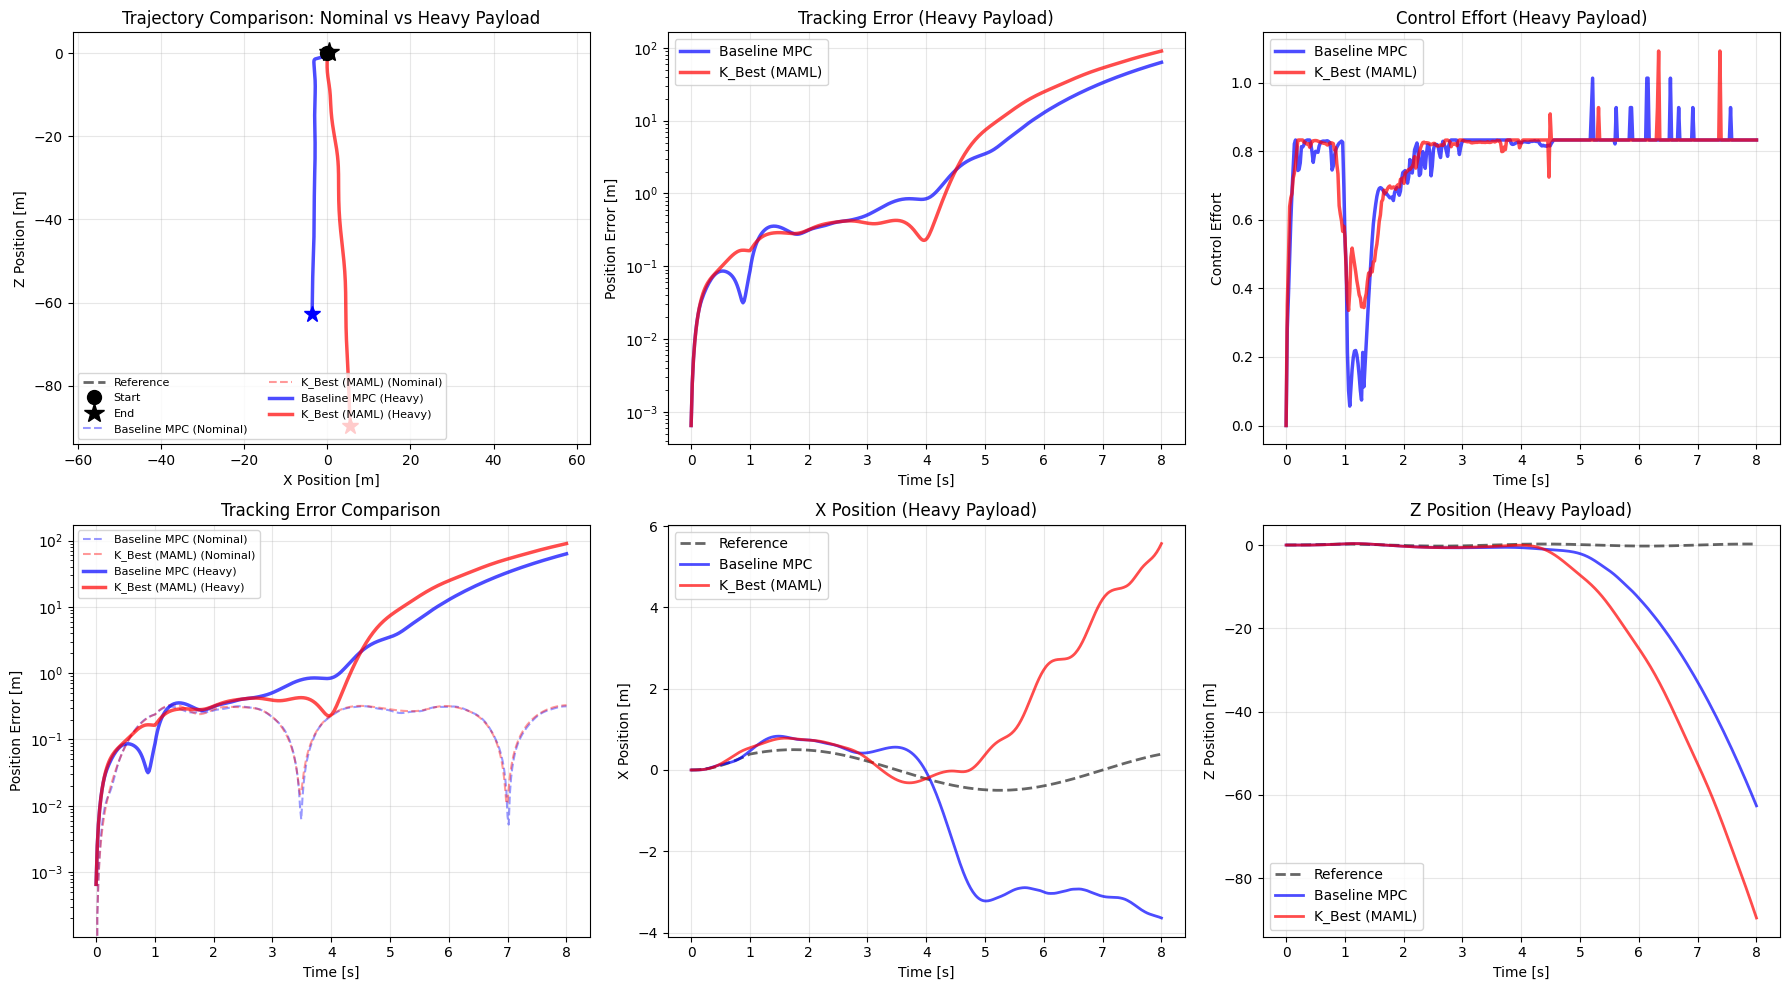

PERFORMANCE COMPARISON: NOMINAL vs HEAVY PAYLOAD
Baseline MPC:
  Nominal mass (0.0350 kg):
    - Average tracking error: 0.2192 m
    - Average control effort:  0.1559
  Heavy payload (0.0525 kg, +50%):
    - Average tracking error: 10.0574 m  (↑4488.6%)
    - Average control effort:  0.7757  (↑397.7%)
K_Best (MAML):
  Nominal mass (0.0350 kg):
    - Average tracking error: 0.2234 m
    - Average control effort:  0.4339
  Heavy payload (0.0525 kg, +50%):
    - Average tracking error: 15.9816 m  (↑7053.7%)
    - Average control effort:  0.7837  (↑80.6%)


In [103]:
# Visualize heavy payload results
fig = plt.figure(figsize=(18, 10))

# Generate reference trajectory
t_ref = np.linspace(0, T_sim, int(T_sim/h))
x_ref_traj = np.array([generate_figure8_reference(t) for t in t_ref])
colors = ['blue', 'red', 'green']

# Plot 1: 2D Trajectory Comparison (Nominal vs Heavy)
ax1 = plt.subplot(2, 3, 1)
plt.plot(x_ref_traj[:, 0], x_ref_traj[:, 2], 'k--', linewidth=2, alpha=0.6, label='Reference')
plt.plot(x_ref_traj[0, 0], x_ref_traj[0, 2], 'ko', markersize=10, label='Start', zorder=5)
plt.plot(x_ref_traj[-1, 0], x_ref_traj[-1, 2], 'k*', markersize=15, label='End', zorder=5)

# Plot nominal (thin lines)
for i, (name, result) in enumerate(results.items()):
    x_traj = result['x']
    plt.plot(x_traj[:, 0], x_traj[:, 2], color=colors[i], linewidth=1.5, 
             alpha=0.4, linestyle='--', label=f'{name} (Nominal)')

# Plot heavy (thick lines)
for i, (name, result) in enumerate(results_heavy.items()):
    x_traj = result['x']
    plt.plot(x_traj[:, 0], x_traj[:, 2], color=colors[i], linewidth=2.5, alpha=0.7, label=f'{name} (Heavy)')
    plt.plot(x_traj[0, 0], x_traj[0, 2], 'o', color=colors[i], markersize=8, zorder=4)
    plt.plot(x_traj[-1, 0], x_traj[-1, 2], '*', color=colors[i], markersize=12, zorder=4)

plt.xlabel('X Position [m]')
plt.ylabel('Z Position [m]')
plt.title('Trajectory Comparison: Nominal vs Heavy Payload')
plt.axis('equal')
plt.legend(fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)

# Plot 2: Heavy Payload Tracking Error
plt.subplot(2, 3, 2)
for i, (name, result) in enumerate(results_heavy.items()):
    x_traj = result['x']
    errors = []
    for j, x in enumerate(x_traj):
        if j < len(x_ref_traj):
            error = np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
            errors.append(error)
    plt.plot(t_ref[:len(errors)], errors, color=colors[i], linewidth=2.5, alpha=0.7, label=name)
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.title('Tracking Error (Heavy Payload)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Heavy Payload Control Effort
plt.subplot(2, 3, 3)
for i, (name, result) in enumerate(results_heavy.items()):
    u_traj = result['u']
    control_effort = np.linalg.norm(u_traj - uhover, axis=1)
    plt.plot(t_ref[:len(control_effort)], control_effort, color=colors[i], 
             linewidth=2.5, alpha=0.7, label=name)
plt.xlabel('Time [s]')
plt.ylabel('Control Effort')
plt.title('Control Effort (Heavy Payload)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Position Error Comparison (Nominal vs Heavy)
plt.subplot(2, 3, 4)
for i, (name, result) in enumerate(results.items()):
    x_traj = result['x']
    errors = []
    for j, x in enumerate(x_traj):
        if j < len(x_ref_traj):
            error = np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
            errors.append(error)
    plt.plot(t_ref[:len(errors)], errors, color=colors[i], linewidth=1.5, 
             alpha=0.4, linestyle='--', label=f'{name} (Nominal)')

for i, (name, result) in enumerate(results_heavy.items()):
    x_traj = result['x']
    errors = []
    for j, x in enumerate(x_traj):
        if j < len(x_ref_traj):
            error = np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
            errors.append(error)
    plt.plot(t_ref[:len(errors)], errors, color=colors[i], linewidth=2.5, 
             alpha=0.7, label=f'{name} (Heavy)')
plt.xlabel('Time [s]')
plt.ylabel('Position Error [m]')
plt.title('Tracking Error Comparison')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 5: X Position over Time
plt.subplot(2, 3, 5)
plt.plot(t_ref, x_ref_traj[:, 0], 'k--', linewidth=2, alpha=0.6, label='Reference')
for i, (name, result) in enumerate(results_heavy.items()):
    x_traj = result['x']
    plt.plot(t_ref[:len(x_traj)], x_traj[:, 0], color=colors[i], 
             linewidth=2, alpha=0.7, label=name)
plt.xlabel('Time [s]')
plt.ylabel('X Position [m]')
plt.title('X Position (Heavy Payload)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Z Position over Time
plt.subplot(2, 3, 6)
plt.plot(t_ref, x_ref_traj[:, 2], 'k--', linewidth=2, alpha=0.6, label='Reference')
for i, (name, result) in enumerate(results_heavy.items()):
    x_traj = result['x']
    plt.plot(t_ref[:len(x_traj)], x_traj[:, 2], color=colors[i], 
             linewidth=2, alpha=0.7, label=name)
plt.xlabel('Time [s]')
plt.ylabel('Z Position [m]')
plt.title('Z Position (Heavy Payload)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('maml_tinympc_heavy_payload.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparative statistics
print("="*70)
print("PERFORMANCE COMPARISON: NOMINAL vs HEAVY PAYLOAD")
print("="*70)

for name in results.keys():
    # Nominal performance
    x_traj_nom = results[name]['x']
    u_traj_nom = results[name]['u']
    avg_error_nom = 0
    for j, x in enumerate(x_traj_nom):
        if j < len(x_ref_traj):
            avg_error_nom += np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
    avg_error_nom /= len(x_traj_nom)
    avg_control_nom = np.mean(np.linalg.norm(u_traj_nom - uhover, axis=1))
    
    # Heavy payload performance
    x_traj_heavy = results_heavy[name]['x']
    u_traj_heavy = results_heavy[name]['u']
    avg_error_heavy = 0
    for j, x in enumerate(x_traj_heavy):
        if j < len(x_ref_traj):
            avg_error_heavy += np.linalg.norm(x[[0,2]] - x_ref_traj[j, [0,2]])
    avg_error_heavy /= len(x_traj_heavy)
    avg_control_heavy = np.mean(np.linalg.norm(u_traj_heavy - uhover, axis=1))
    
    print(f"{name}:")
    print(f"  Nominal mass ({mass:.4f} kg):")
    print(f"    - Average tracking error: {avg_error_nom:.4f} m")
    print(f"    - Average control effort:  {avg_control_nom:.4f}")
    print(f"  Heavy payload ({mass_heavy:.4f} kg, +50%):")
    print(f"    - Average tracking error: {avg_error_heavy:.4f} m  (↑{(avg_error_heavy/avg_error_nom-1)*100:.1f}%)")
    print(f"    - Average control effort:  {avg_control_heavy:.4f}  (↑{(avg_control_heavy/avg_control_nom-1)*100:.1f}%)")

print("="*70)